In [15]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 5.0 MB/s 
     |████████████████████████████████| 81 kB 10.2 MB/s 
     |████████████████████████████████| 209 kB 47.6 MB/s 
     |████████████████████████████████| 78 kB 7.6 MB/s 
     |████████████████████████████████| 50 kB 5.5 MB/s 
     |████████████████████████████████| 147 kB 41.6 MB/s 
     |████████████████████████████████| 112 kB 51.8 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=4346ff32948d0bf9d30f0fb38f6f7d8a45e5e3c4726b77522993bb0afb5371f6
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
import pandas as pd
import pickle
import optuna as op

In [3]:
path = '/content/drive/MyDrive/Univerui/Kursinis/'

# Loading Data

In [4]:
train_data = pd.read_csv(path+'train_dataset.csv')
valid_data = pd.read_csv(path+'valid_dataset.csv')
test_data = pd.read_csv(path+'test_dataset.csv')

train_data.head()

,pslist.nproc,pslist.nppid,pslist.avg_threads,pslist.avg_handlers,dlllist.ndlls,dlllist.avg_dlls_per_proc,handles.nhandles,handles.avg_handles_per_proc,handles.nfile,handles.nevent,...,svcscan.nservices,svcscan.kernel_drivers,svcscan.fs_drivers,svcscan.process_services,svcscan.shared_process_services,svcscan.nactive,callbacks.ncallbacks,callbacks.nanonymous,callbacks.ngeneric,Class
0,-1.000000,0.00,-0.489278,-0.525639,-0.572505,-0.480974,-0.447922,-0.563055,-0.451613,-0.348355,...,-0.500000,0.0,0.0,0.000000,-0.5,-1.5,1.0,0.0,0.0,1
1,-1.333333,0.00,-0.409560,-0.859858,-0.838041,-0.740434,-0.765124,-0.835619,-0.559908,-0.767525,...,-1.166667,-1.0,0.0,-0.333333,-1.5,-4.0,1.0,0.0,0.0,1
2,1.000000,-0.75,0.491920,0.519117,0.783427,0.563137,0.853235,0.475160,0.670507,1.094421,...,0.500000,1.0,0.0,1.000000,0.5,1.5,1.0,0.0,0.0,0
3,1.666667,0.75,-0.157661,-0.547790,-0.062147,-0.542530,-0.057075,-0.542748,-0.375576,0.030043,...,-0.500000,0.0,0.0,0.000000,-0.5,0.5,-32.0,0.0,0.0,1
4,3.000000,0.50,0.277606,0.330270,1.250471,0.393810,1.172804,0.287495,0.937788,1.159514,...,0.000000,1.0,0.0,0.000000,0.5,2.0,0.0,0.0,0.0,0


In [5]:
X_train = train_data.drop('Class', axis=1)
y_train = train_data['Class']

X_test = test_data.drop('Class', axis=1)
y_test = test_data['Class']

X_valid = valid_data.drop('Class', axis=1)
y_valid = valid_data['Class']

len(X_train), len(y_train), len(X_test), len(y_test), len(X_valid), len(y_valid)

(40940, 40940, 8790, 8790, 8866, 8866)

# Helper functions

In [6]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [29]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

sns.light_palette("seagreen", as_cmap=True)

def plot_confusion_matrix(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  labels = ['Benign', 'Malware']

  plt.figure(1, figsize=(9,6))
  axis = sns.heatmap(cm, annot=True, cbar=False, cmap='Greens', fmt='d')

  axis.set_xticklabels(labels)
  axis.set_yticklabels(labels)

  axis.set(ylabel='Tikros reikšmės', xlabel='Prognozuotos reikšmės')

  plt.show()


# Classification using Support Vectore Machine Classifier

## Baseline model

In [7]:
from sklearn.svm import SVC

baseline_svc = SVC(random_state=42)

baseline_svc.fit(X_train, y_train)

y_pred = baseline_svc.predict(X_test)

baseline_svc_results = calculate_results(y_test, y_pred)
baseline_svc_results

{'accuracy': 54.12969283276451,
 'precision': 0.7634846727994057,
 'recall': 0.5412969283276451,
 'f1': 0.4283059720195139}

## Hyperparameter tuning with optuna

In [19]:
def objective_svc(trial):
  kernel=trial.suggest_categorical('kernel',['rbf','poly','linear','sigmoid'])
  c=trial.suggest_float("C",0.1,3.0,log=True)
  gamma=trial.suggest_categorical('gamma',['auto','scale'])
  degree=trial.suggest_int("degree",1,3,log=True)

  model = SVC(kernel=kernel, degree=degree, gamma=gamma, C=c)
 
  model.fit(X_train, y_train)

  accuracy = model.score(X_test, y_test)
  return accuracy

In [20]:
study = op.create_study(direction='maximize')
study.optimize(objective_svc, n_trials=25, n_jobs=1)

[I 2022-11-02 09:51:58,719] A new study created in memory with name: no-name-0f2df6e0-b00c-4dcd-a6e8-6250efe8273a
[I 2022-11-02 09:52:01,160] Trial 0 finished with value: 0.9993174061433447 and parameters: {'kernel': 'linear', 'C': 0.8600820964240428, 'gamma': 'auto', 'degree': 3}. Best is trial 0 with value: 0.9993174061433447.
[I 2022-11-02 09:55:23,249] Trial 1 finished with value: 0.5359499431171786 and parameters: {'kernel': 'poly', 'C': 0.2133033986277771, 'gamma': 'scale', 'degree': 2}. Best is trial 0 with value: 0.9993174061433447.
[I 2022-11-02 09:55:24,775] Trial 2 finished with value: 0.9992036405005689 and parameters: {'kernel': 'linear', 'C': 0.5732917793485722, 'gamma': 'auto', 'degree': 1}. Best is trial 0 with value: 0.9993174061433447.
[I 2022-11-02 09:57:38,153] Trial 3 finished with value: 0.5544937428896474 and parameters: {'kernel': 'sigmoid', 'C': 0.4398965696385378, 'gamma': 'auto', 'degree': 3}. Best is trial 0 with value: 0.9993174061433447.
[I 2022-11-02 10:0

In [22]:
trial=study.best_trial
print("Best Tuning Parameters : {} \n with accuracy of : {:.2f} %".format(trial.params,trial.value*100))

Best Tuning Parameters : {'kernel': 'rbf', 'C': 1.6313957488592703, 'gamma': 'auto', 'degree': 2} 
 with accuracy of : 100.00 %


## Training SVM classifier with best parameters

In [32]:
svc_model = SVC(**trial.params)

svc_model.fit(X_train, y_train)

y_pred = svc_model.predict(X_test)

svc_model_results = calculate_results(y_test, y_pred)
svc_model_results

{'accuracy': 100.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}

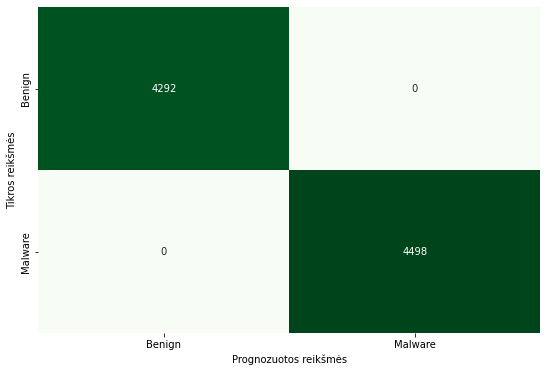

In [33]:
plot_confusion_matrix(y_test, y_pred)

In [34]:
pickle.dump(svc_model, open(path+'models/SVC_model.sav', 'wb'))

# Classification using KNN

## Baseline model

In [9]:
from sklearn.neighbors import KNeighborsClassifier

baseline_knn = KNeighborsClassifier()

baseline_knn.fit(X_train, y_train)

y_pred = baseline_knn.predict(X_test)

baseline_knn_results = calculate_results(y_test, y_pred)
baseline_knn_results

{'accuracy': 100.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}

In [14]:
y_valid_pred = baseline_knn.predict(X_valid)
calculate_results(y_valid, y_valid_pred)

{'accuracy': 100.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}

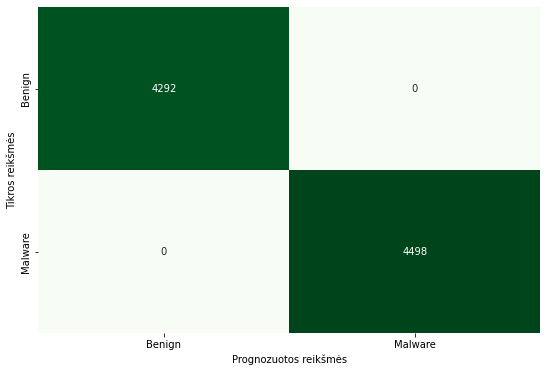

In [30]:
y_pred = baseline_knn.predict(X_test)
plot_confusion_matrix(y_test, y_pred)

In [16]:
pickle.dump(baseline_knn, open(path+'models/KNN_model.sav', 'wb'))

# Classification using LDA

## Baseline model

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

baseline_lda = LinearDiscriminantAnalysis()

baseline_lda.fit(X_train, y_train)

y_pred = baseline_lda.predict(X_test)

baseline_lda_results = calculate_results(y_test, y_pred)
baseline_lda_results

{'accuracy': 99.59044368600682,
 'precision': 0.9959044368600682,
 'recall': 0.9959044368600682,
 'f1': 0.9959044368600682}

In [13]:
y_valid_pred = baseline_lda.predict(X_valid)
calculate_results(y_valid, y_valid_pred)

{'accuracy': 99.63907060681254,
 'precision': 0.9963923859744261,
 'recall': 0.9963907060681254,
 'f1': 0.9963907347221087}

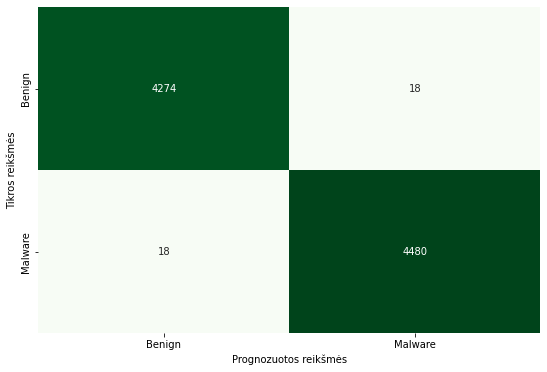

In [31]:
y_pred = baseline_lda.predict(X_test)
plot_confusion_matrix(y_test, y_pred)

In [17]:
pickle.dump(baseline_lda, open(path+'models/LDA_model.sav', 'wb'))